#  Google Colab Guide: Detecting Badass One Punch Man Heroes on Android

This note book is a part of :https://medium.com/p/333c9d4149/edit




Jupyter notebook providing steps to retrain a **ModelZoo** model with custom dataset.

It runs in Google Colab using Tensorflow **Object Detection API.**

Requirements are only dataset images and annotations file.

**Colab Runtime type: Python3, GPU enabled.**



# Mounting Google Drive
Having  access to our Google Drive's account and structuring our workspace there are recommended. This way we do not lose our trained model when Colab frees up memory, this usually happen when training is done and Colab become in active for sometime. Plus you can retrained model from current check point instead of starting from zero.


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('Gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at Gdrive


# Overview of workspace structure

```
TensorFlow
├─ addons
│   └─ labelImg
├─ models
│   ├─ official
│   ├─ research
│   ├─ samples
│   └─ tutorials
└─ workspace
    └─ training_demo

training_demo
├─ train 
│   ├─ Images    
│   └─ Annotations     
├─ test 
│   ├─ Images   
│   └─ Annotations                  
├─ pre-trained-model
├─ fine_tuned_model
└─ Frozen_Inf
└─ Frozen_tflite



```



# **Installing required packages and repositories**

In [0]:
import os
import shutil

%cd /content/Gdrive/My Drive

if not os.path.exists('Tensorflow'):
  os.makedirs('Tensorflow')

%cd /content/Gdrive/My Drive/Tensorflow

#tensorflow models section has an object detection library
!git clone --quiet https://github.com/tensorflow/models.git

#this reposity has what it takes to prepare tfrecord files, bing thanks to Tony608
!git clone --quiet https://github.com/Tony607/object_detection_demo
 
#install PyDrive so we can unload our dataset from Google Drive
!pip install PyDrive

# protobuf is needed for creating py files from models library above
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

# !pip install -q Cython contextlib2 pillow lxml matplotlib

# pycoco for coco scores
!pip install -q pycocotools

# creating py files from protos
%cd /content/Gdrive/My Drive/Tensorflow/models/research
!protoc object_detection/protos/*.proto --python_out=.

# setting path, if not set, python can not use object detection library (from models)
os.environ['PYTHONPATH'] += ':/content/Gdrive/My Drive/Tensorflow/models/research/:/content/Gdrive/My Drive/Tensorflow/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content/Gdrive/My Drive
/content/Gdrive/My Drive/Tensorflow
fatal: destination path 'models' already exists and is not an empty directory.
fatal: destination path 'object_detection_demo' already exists and is not an empty directory.
     |████████████████████████████████| 993kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive
Selecting previously unselected package python-bs4.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselec


# Loading Dataset from Google Drive

# Recommended zip file structure



```
.zip file
├─ train 
│   ├─ Images 
│   │   └─ image files (filename format: objectclass_id.jpg)
│   └─ Annotations 
│      └─ Annotations (filename format: objectclass_id.xml)
└─ test 
    ├─ Images 
    │   └─ image files (filename format: objectclass_id.jpg)
    └─ Annotations 
        └─ Annotations (filename format: objectclass_id.xml)
```





Learn about  how make your own dataset here:
https://medium.com/p/333c9d4149/edit


# Getting FileID
To upload your file from Google Drive, you will need to provide file ID. To do that, **right click** on your selected file, choose **get shareable link**, then copy your file ID.





In [0]:
import os

%cd /content/Gdrive/My Drive/Tensorflow
if not os.path.exists('workspace'):
  os.makedirs('workspace')

%cd /content/Gdrive/My Drive/Tensorflow/workspace

#####replace training_OPM1 with your training dir name#####
if not os.path.exists('training_OPM1'):
  os.makedirs('training_OPM1')

training_OPM1 = '/content/Gdrive/My\ Drive/Tensorflow/workspace/training_OPM1'
%cd {training_OPM1}

fileId = '1KOh1X85Yr0PYbfkFhcWA8ze0zM0kizWC'

from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Create GoogleDrive instance with authenticated GoogleAuth instance.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create GoogleDriveFile instance 
fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)


/content/Gdrive/My Drive/Tensorflow
/content/Gdrive/My Drive/Tensorflow/workspace
/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
Extracted zip file 1KOh1X85Yr0PYbfkFhcWA8ze0zM0kizWC.zip


# Converting xml to csv file

In [0]:
training_OPM1 = '/content/Gdrive/My\ Drive/Tensorflow/workspace/training_OPM1'
%cd {training_OPM1}

# modified from https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/

# Convert train folder annotation xml files to a single csv file,
!python /content/Gdrive/My\ Drive/Tensorflow/object_detection_demo/xml_to_csv.py \
-i train/Annotations -o train/train_labels.csv -l train/Annotations

!python /content/Gdrive/My\ Drive/Tensorflow/object_detection_demo/xml_to_csv.py \
-i test/Annotations -o test/test_labels.csv


/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
Successfully converted xml to csv.
Generate `train/Annotations/label_map.pbtxt`
Successfully converted xml to csv.


# Creating label map 

In [0]:
import pandas as pd

pd = pd.read_csv('test/test_labels.csv')
classes = sorted(pd['class'].unique())

#create pb file of label map
#mapping of your classes with its corresponding identification number (id) in 
with open('label_map.pbtxt', 'w') as txtl:
  for i, class_name in enumerate(classes):
    txtl.write("item {\n  id: %s\n  name: '%s'\n}\n\n"%(i+1, class_name))

with open('label_map.pbtxt') as txtl:
  print(txtl.read())  
    
    
    
#create text file of label map, list of all classes  
#this will be used later along with tflite frozen graph on Android Studio
with open('OPM_label.txt', 'w') as txt:
  txt.write('???\n')
  for classname in classes:
    txt.write('{}\n'.format(classname))
       
#####replace OPM_label with your text file name#####  
with open('OPM_label.txt') as txt:
  print(txt.read())  

item {
  id: 1
  name: 'Genos'
}

item {
  id: 2
  name: 'Saitama'
}

item {
  id: 3
  name: 'Tatsumaki'
}


???
Genos
Saitama
Tatsumaki



#Generate tfrecord file

In [0]:
%cd {training_OPM1}
%rm -rf tfrecord

if not os.path.exists('tfrecord'):
  os.makedirs('tfrecord')

  
# Generate `train.record`
!python /content/Gdrive/My\ Drive/Tensorflow/object_detection_demo/generate_tfrecord.py \
--csv_input=train/train_labels.csv \
--output_path=tfrecord/train.record \
--img_path=train/train \
--label_map label_map.pbtxt

# Generate `val.record`
!python /content/Gdrive/My\ Drive/Tensorflow/object_detection_demo/generate_tfrecord.py \
--csv_input=test/test_labels.csv \
--output_path=tfrecord/val.record \
--img_path=test/Images \
--label_map label_map.pbtxt


/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
W0702 10:06:27.770410 139749907728256 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/object_detection_demo/generate_tfrecord.py:134: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0702 10:06:27.771137 139749907728256 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/object_detection_demo/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0702 10:06:27.797103 139749907728256 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1/tfrecord/train.record
W0702 10:06:35.613215 139654745081728 deprecation_wrapper.py:119] From /content/Gdrive/My Driv

# Download pre trained model

In [0]:
%cd {training_OPM1}

import os
import shutil
import glob
from urllib.request import urlretrieve
import tarfile


#list of pretrained models can be found at:
#https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
MODEL = 'ssd_mobilenet_v2_quantized_300x300_coco_2019_01_03'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'ssd_model'

if not (os.path.exists(MODEL_FILE)):
  urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

#remove zip file
os.remove(MODEL_FILE)

if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)


/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1


# Configuring a Training Pipeline

In [0]:
# modified from https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/
training_OPM1 = '/content/Gdrive/My\ Drive/Tensorflow/workspace/training_OPM1'
%cd {training_OPM1}

import re
import os

pipeline_fn = '/content/Gdrive/My Drive/Tensorflow/models/research/object_detection/samples/configs/ssd_mobilenet_v2_quantized_300x300_coco.config'
checkpoint = os.path.join('.', 'ssd_model/model.ckpt')
train_record = os.path.join('.', 'tfrecord/train.record')
val_record = os.path.join('.', 'tfrecord/val.record')
label_map = os.path.join('.', 'label_map.pbtxt')

# generate examples by augmenting existing images in tfrecords
num_eval = len(os.listdir('test/Images'))

# specify classes
num_class = len(classes)

# more steps of training gives higher accuracy
num_steps = 15000

#this specific arguably help speed up training process as it fits in Colabe's Tesla K80 GPU memory for selected model.
#I do not reccomend anything beyond size of 24(default) as I have tried, found training process significantly slower.
batch_size = 12
with open(pipeline_fn) as f:
    s = f.read()
with open(pipeline_fn, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(val_record), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_class), s)
    
    s = re.sub('num_examples: [0-9]+',
               'num_examples: {}'.format(num_eval), s)
    
    f.write(s)
    print(s)
    

/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
# Quantized trained SSD with Mobilenet v2 on MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 3
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
      

# Training the model

In [0]:
%cd {training_OPM1}

pipeline_fn = '/content/Gdrive/My\ Drive/Tensorflow/models/research/object_detection/samples/configs/ssd_mobilenet_v2_quantized_300x300_coco.config'
obj_detection = '/content/Gdrive/My\ Drive/Tensorflow/models/research/object_detection'

!python {obj_detection + '/model_main.py'} \
    --pipeline_config_path={pipeline_fn}\
    --model_dir=fine_tuned_model \
    --alsologtostderr\
 
%ls

/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
W0702 14:32:33.873605 140451678713728 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0702 14:32:34.092158 140451678713728 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0702 14:32:34.186360 140451678713728 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0702 14:32:34.256883 140451678713728 

## **Exporting** a Trained Inference Graph


In [0]:
%cd {training_OPM1}



import re
import os
import numpy as np

#get the last model's check point
ckpt_files = [ckpt.replace('.meta', '') for ckpt in os.listdir('fine_tuned_model') if 'model.ckpt-' and '.meta' in ckpt]
steps = [(int(re.findall('\d+', ckpt_file)[0])) for ckpt_file in ckpt_files]
last_step = np.argmax(steps)
last_model = ckpt_files[last_step]

#exporting graph for testing
!python {obj_detection + '/export_inference_graph.py'} \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fn} \
    --output_directory=Frozen_Inf \
    --trained_checkpoint_prefix=fine_tuned_model/$last_model 
    
print('Finished exporting')

/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
W0702 15:34:40.808868 140495768500096 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0702 15:34:40.899994 140495768500096 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0702 15:34:40.965599 140495768500096 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/object_detection/export_inference_graph.py:156: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0702 15:34:40.966336 140495768500096 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/object_detection/export_inference_graph.py:139: The name tf.gfile.GFile is deprecated. Pl

# Runing inference test

Unless you want to test your model, feel free to skip this part

/content/Gdrive/My Drive/Tensorflow/models/research/object_detection


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


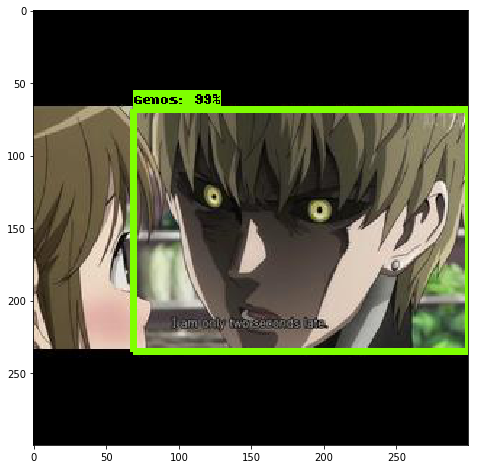

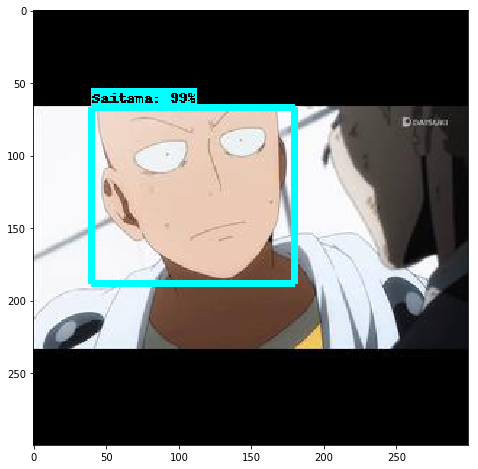

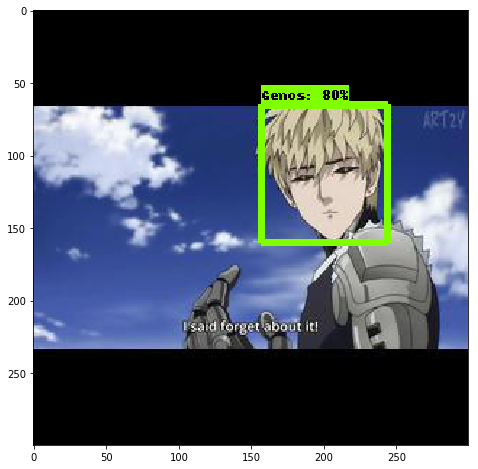

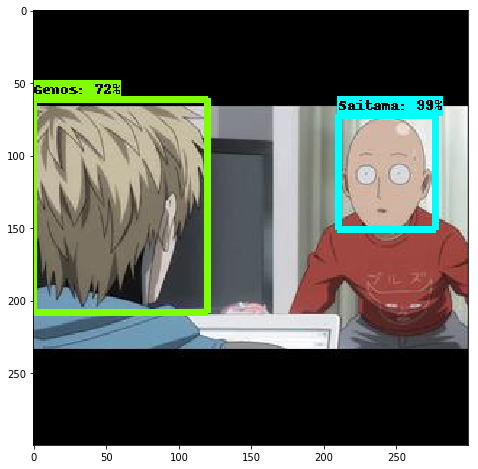

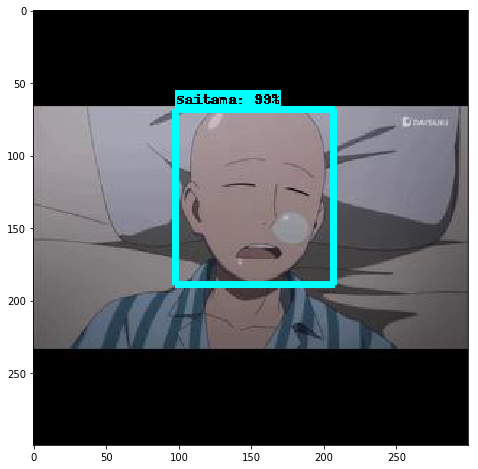

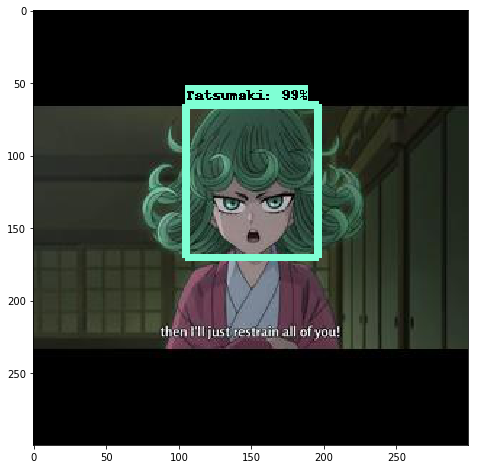

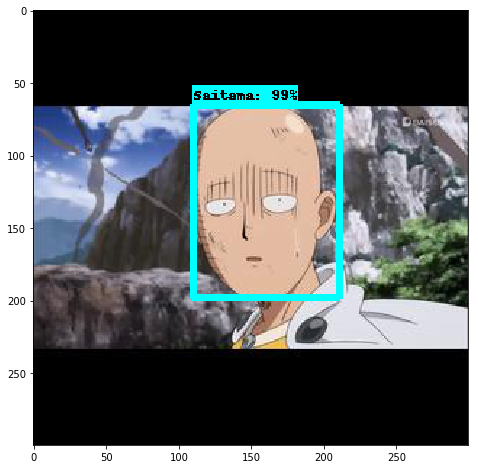

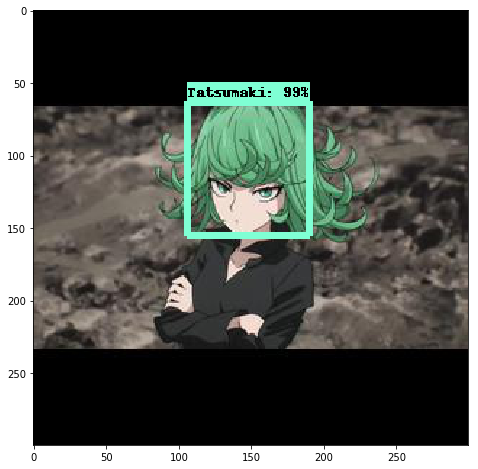

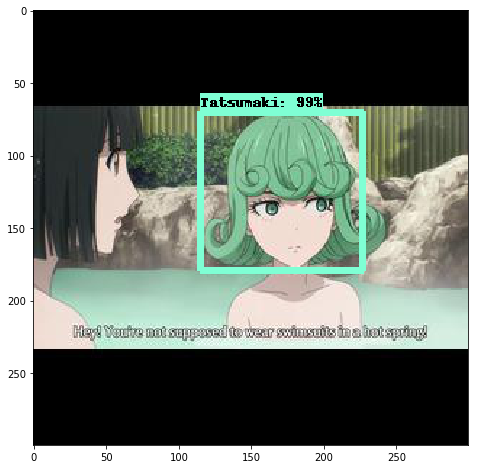

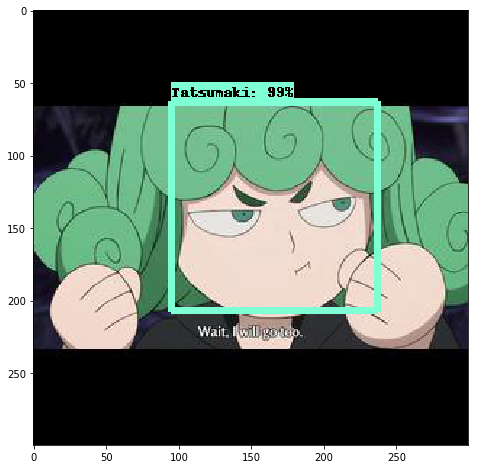

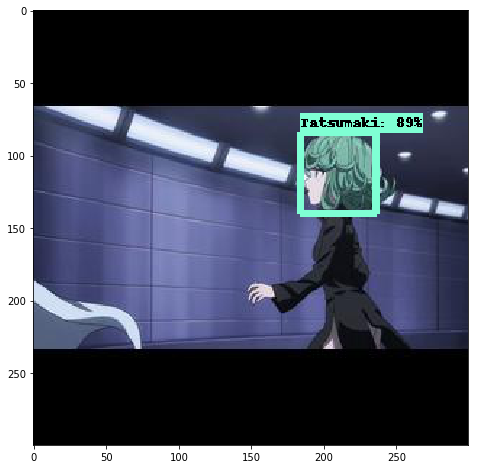

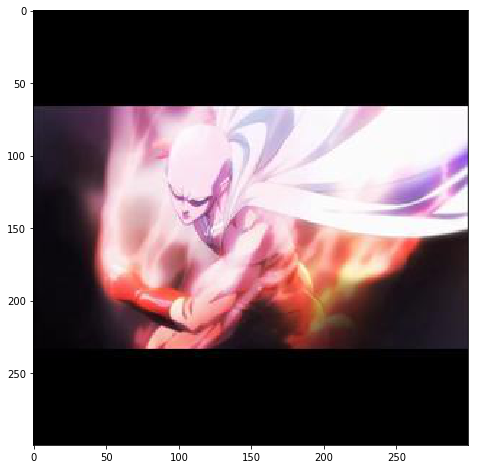

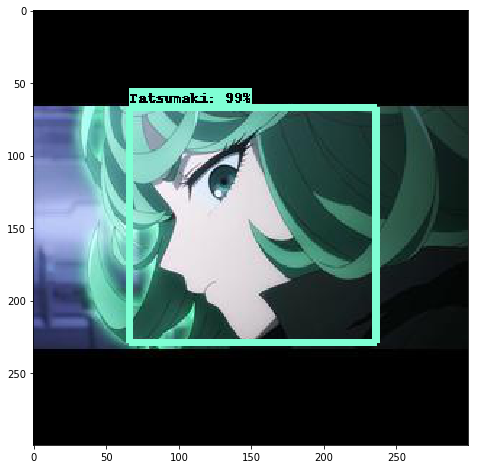

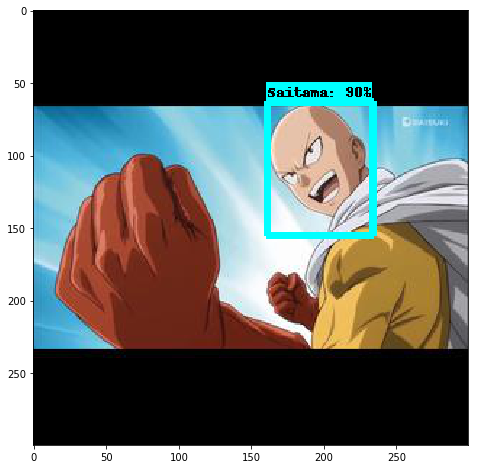

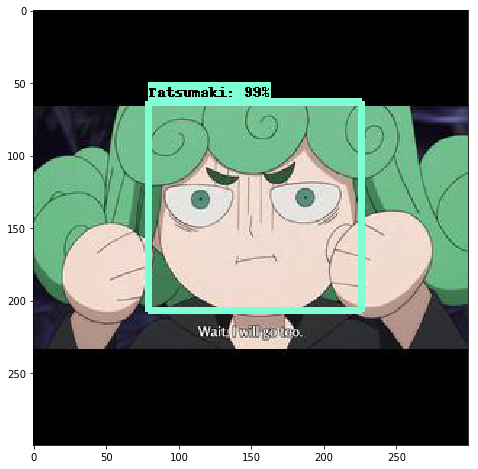

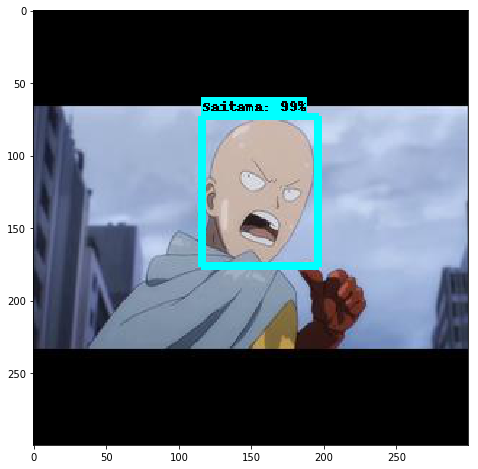

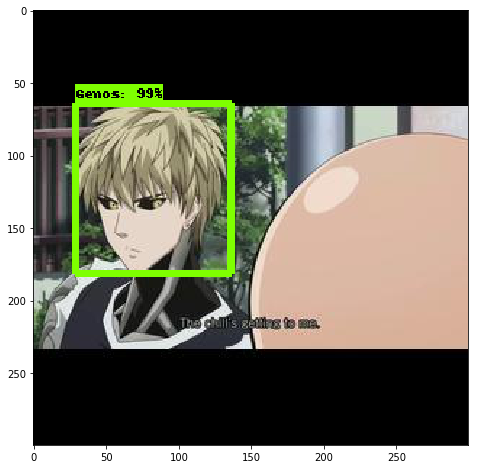

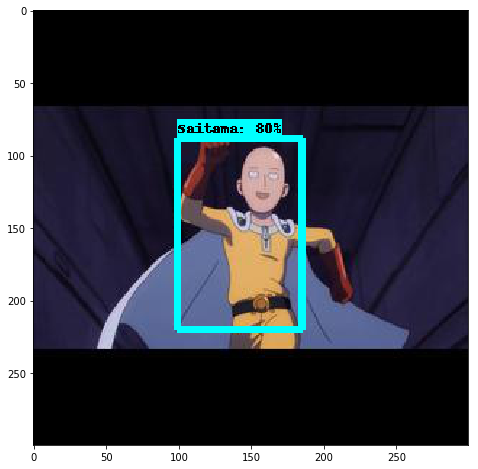

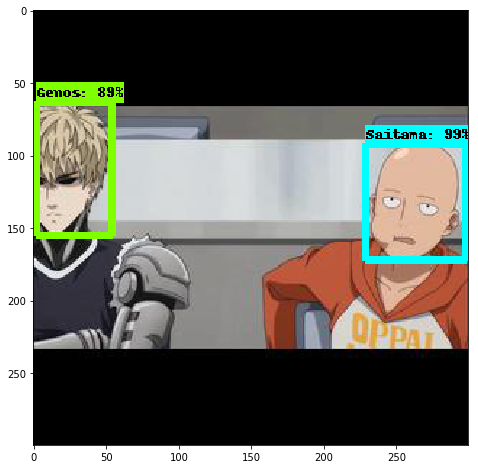

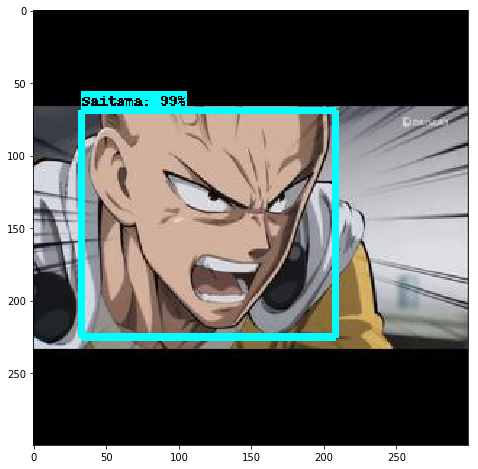

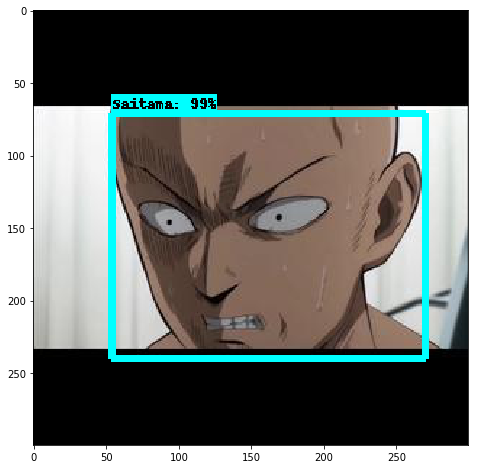

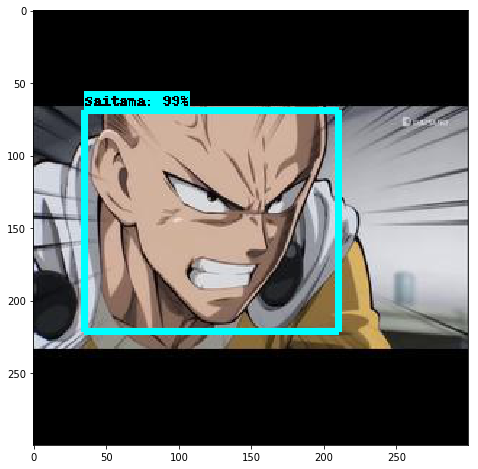

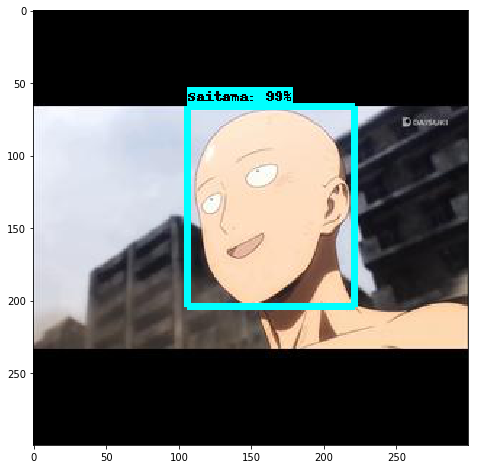

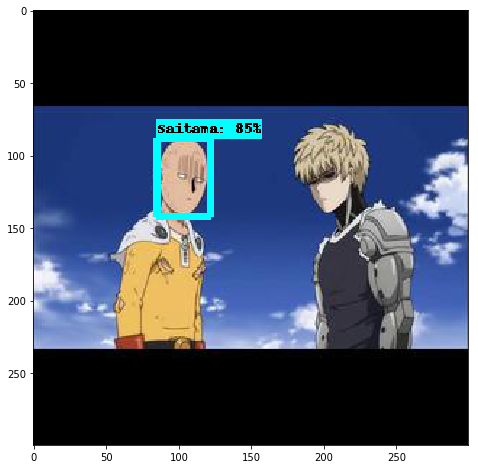

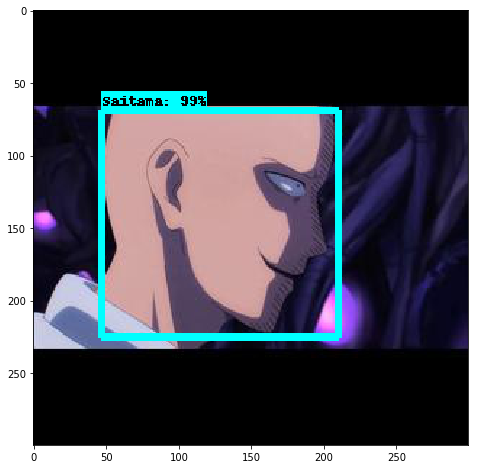

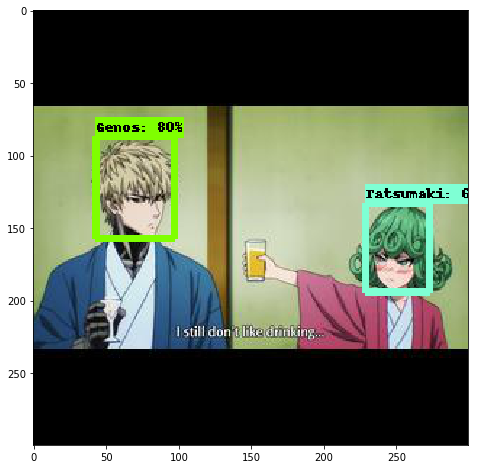

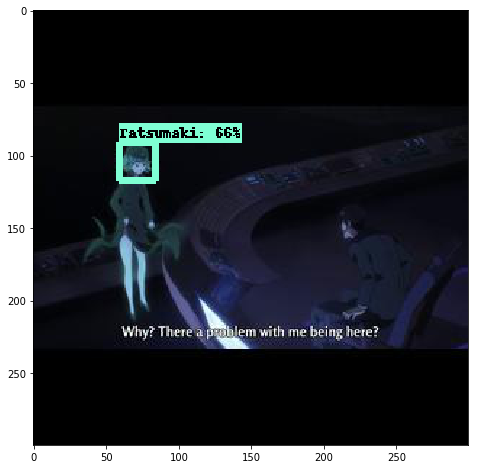

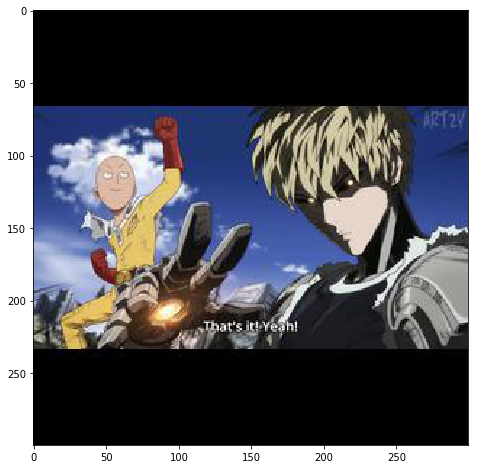

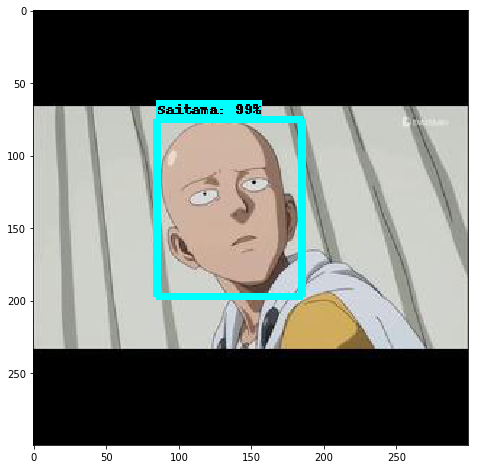

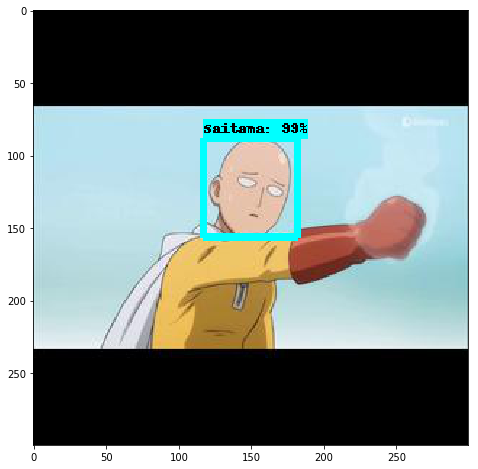

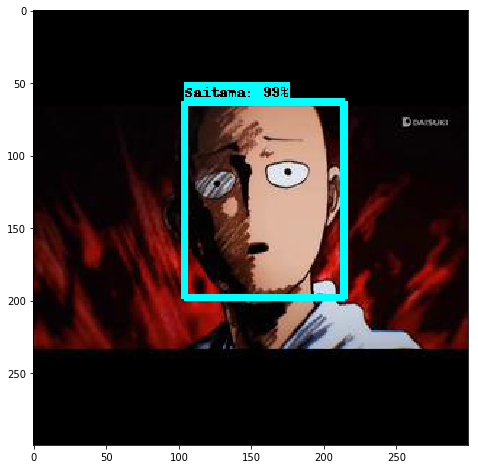

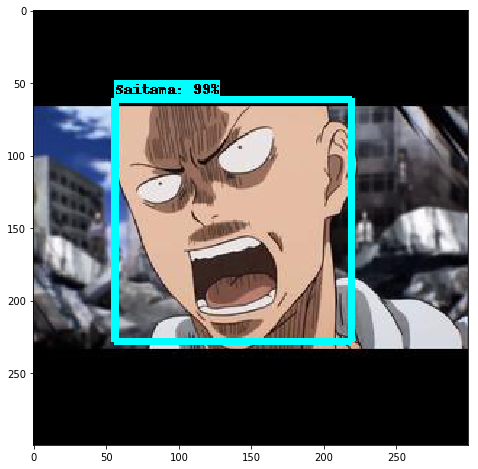

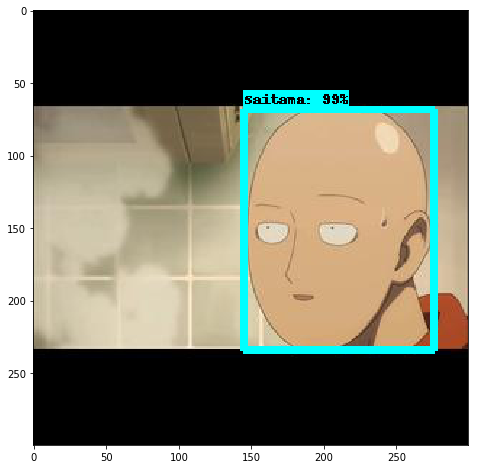

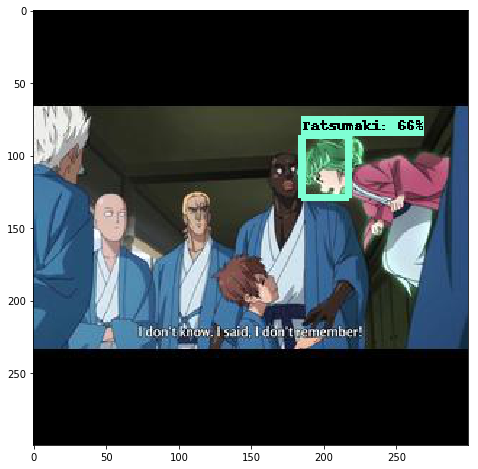

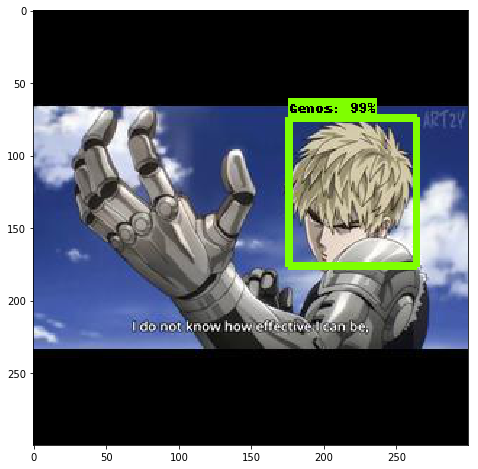

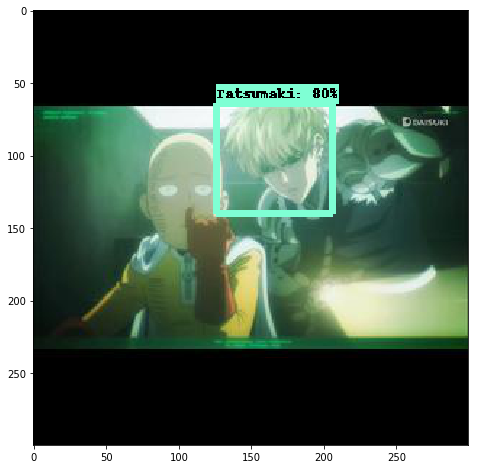

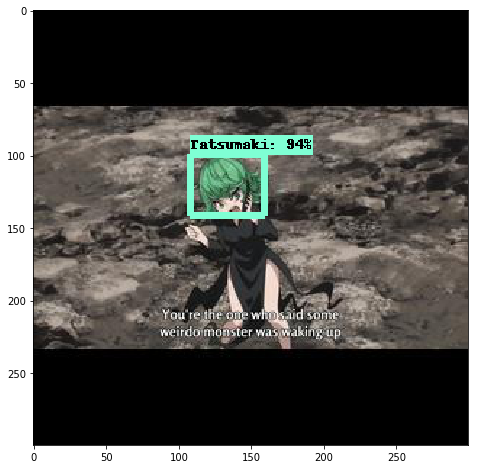

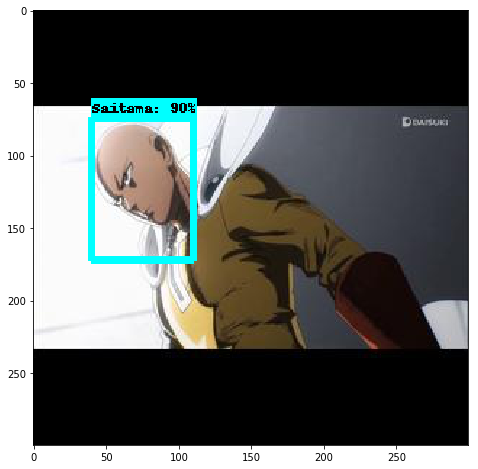

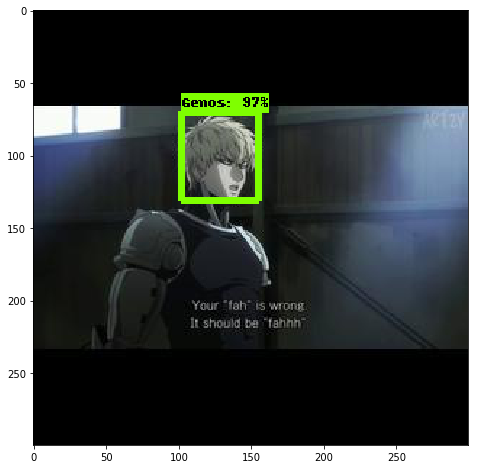

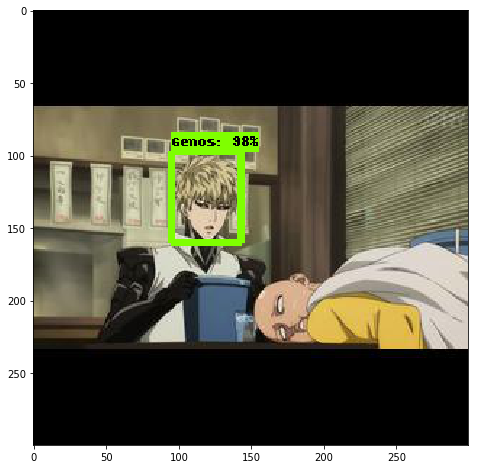

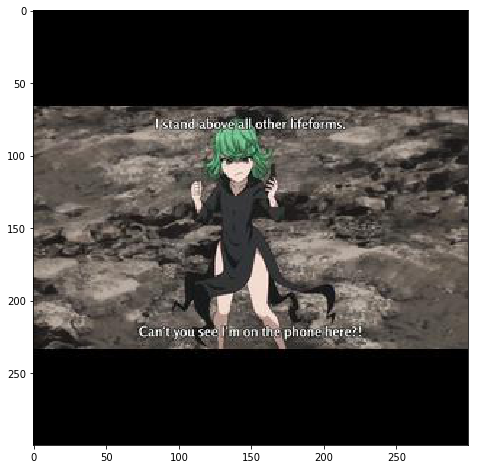

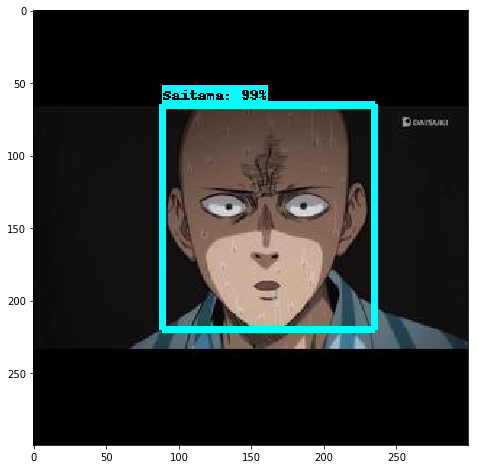

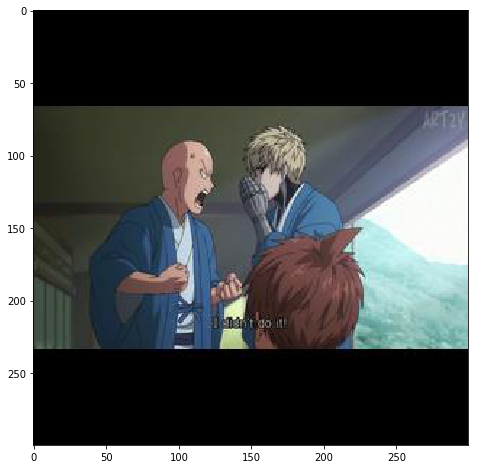

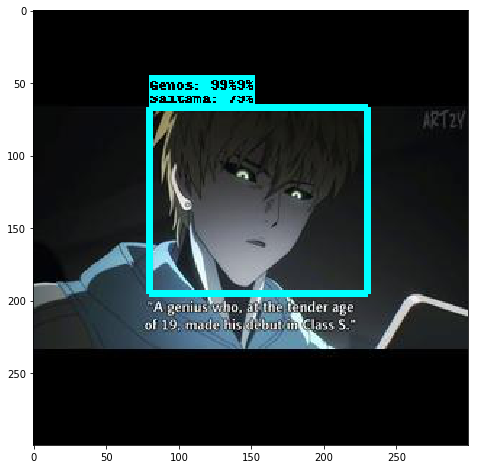

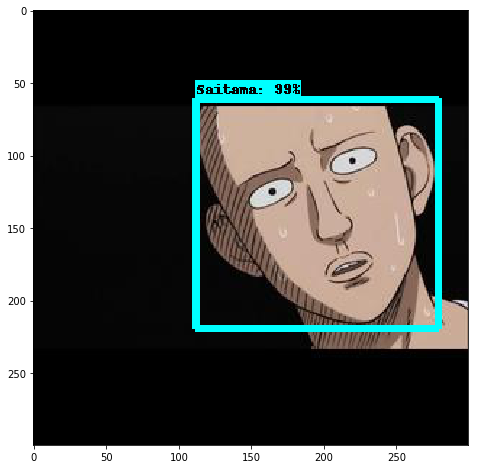

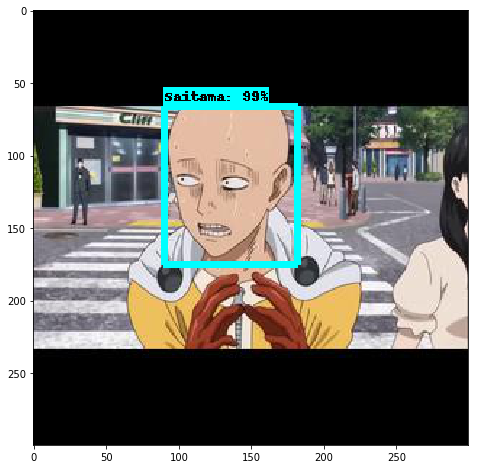

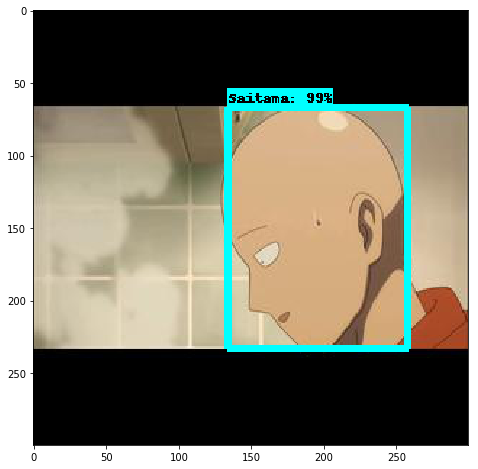

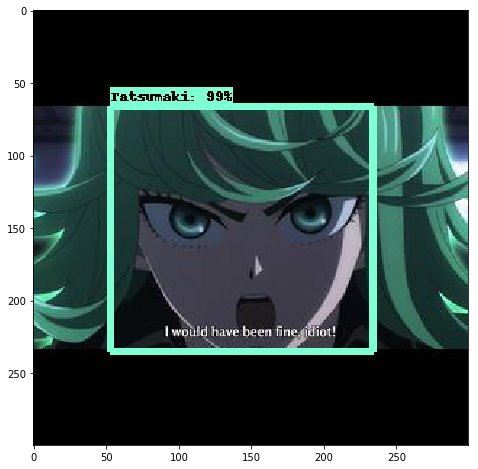

In [0]:
# modified from https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/
%cd {obj_detection}

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if tf.__version__ < '1.4.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline

root_dir = '/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1'


from utils import label_map_util

from utils import visualization_utils as vis_util

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = os.path.join(root_dir, 'Frozen_Inf_10000/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(root_dir, 'label_map.pbtxt')

NUM_CLASSES = 3

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)



def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


                            
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = os.path.join(root_dir, 'test/Images')
fnames = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, fn) for fn in fnames]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


#positional follow key = put all positional arg first then you can add key arg later
#Keep it in list format TEST_IMAGE_PATHS[a:b], if single index is input
#TEST_PATH becomes str, will be enumerated as a single str causing [Errno 21] Is a directory: '/' as a result

for image_path in TEST_IMAGE_PATHS[0:]:
  if not os.path.basename(image_path) == '.DS_Store':
    
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array( 
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      min_score_thresh=0.60,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=5)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Exporting Frozen Graph For Tensorflow lite

In [0]:
%cd {training_OPM1}


import re
import os
import numpy as np

ckpt_files = [ckpt.replace('.meta', '') for ckpt in os.listdir('fine_tuned_model') if 'model.ckpt-' and '.meta' in ckpt]
steps = [(int(re.findall('\d+', ckpt_file)[0])) for ckpt_file in ckpt_files]
last_step = np.argmax(steps)
last_model = ckpt_files[last_step]

pipeline_fn = '/content/Gdrive/My\ Drive/Tensorflow/models/research/object_detection/samples/configs/ssd_mobilenet_v2_quantized_300x300_coco.config'

# freezing graph for tensorflow lite for android use
!python /content/Gdrive/My\ Drive/Tensorflow/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path={pipeline_fn} \
    --trained_checkpoint_prefix=fine_tuned_model/$last_model \
    --output_directory=Frozen_lite\
    --add_postprocessing_op=true

/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
W0703 07:22:19.541932 140271531562880 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0703 07:22:19.632887 140271531562880 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0703 07:22:19.694846 140271531562880 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/object_detection/export_tflite_ssd_graph.py:143: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0703 07:22:19.695472 140271531562880 deprecation_wrapper.py:119] From /content/Gdrive/My Drive/Tensorflow/models/research/object_detection/export_tflite_ssd_graph.py:133: The name tf.gfile.GFile is deprecated. 

# Converting frozen graph to tflite file format

# For quantized version

In [0]:
# converting frozen graph to obtain tflite, used on Android later
%cd {training_OPM1}

!tflite_convert  --graph_def_file=Frozen_lite/tflite_graph.pb \
#####replace OPM_uint8 with your tflite file name#####
--output_file=Frozen_lite/OPM_uint8.tflite \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--input_shape=1,300,300,3 \
--inference_type=QUANTIZED_UINT8 \
--mean_values=128 \
--std_dev_values=128 \
--change_concat_input_ranges=false \
--allow_custom_ops 

/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1
2019-07-03 07:22:38.042334: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-07-03 07:22:38.062580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-07-03 07:22:38.063014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2019-07-03 07:22:38.063273: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.0
2019-07-03 07:22:38.064449: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10.0
2019-07-03 07:22:38.065631: I tensorflow/stream_executor/platform/default/dso_load

# For float version

In [0]:
# converting the frozen graph to obtain tflite, used on Android later
!tflite_convert   --graph_def_file=Frozen_lite/tflite_graph.pb \
--output_file=Frozen_lite/OPM_uint8.tflite \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--input_shape=1,300,300,3 \
--allow_custom_ops 

# Downloading files to local computer



In [0]:
%cd {training_OPM1 +'/Frozen_lite'}
  
from google.colab import files
files.download('OPM_uint8.tflite')
files.download(training_OPM1 + '/OPM_label.txt')

/content/Gdrive/My Drive/Tensorflow/workspace/training_OPM1/Frozen_lite_10000
